In [28]:
import imageio
import pydicom
import numpy as np
import pandas as pd
from torch.utils import data
import os
import torch
import torchvision
import random
import seaborn as sns
import cv2
import albumentations
from torch.utils.data import DataLoader
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
ISIC_PATH = "/home/maparla/DeepLearning/Datasets/ISIC2019/"
ISIC_TRAIN_ROOT_PATH = ISIC_PATH + "ISIC_2019_Training_Input"

ROOT_PATH = {"":ISIC_TRAIN_ROOT_PATH, "train":ISIC_TRAIN_ROOT_PATH,
             "validation":ISIC_TRAIN_ROOT_PATH}

In [3]:
ISIC_TRAIN_DF_TRUTH = pd.read_csv(ISIC_PATH + "ISIC_2019_Training_GroundTruth.csv")
ISIC_TRAIN_DF_METADATA = pd.read_csv(ISIC_PATH + "ISIC_2019_Training_Metadata.csv")

In [4]:
DIAGNOSTIC_CATEGORIES = {"Melanoma":"MEL", "Melanocytic nevus":"NV", "Basal cell carcinoma":"BCC",
                        "Actinic keratosis":"AK", "Benign keratosis":"BKL", "Dermatofibroma":"DF",
                        "Vascular lesion":"VASC", "Squamous cell carcinoma":"SCC", "None of the others":"UNK"}
CATEGORIES_DIAGNOSTIC = {v: k for k, v in DIAGNOSTIC_CATEGORIES.items()}
CATEGORIES_CLASS = {"MEL":0, "NV":1, "BCC":2, "AK":3, "BKL":4, "DF":5, "VASC":6, "SCC":7, "UNK":8}
CLASS_CATEGORIES = {v: k for k, v in CATEGORIES_CLASS.items()}

In [5]:
ISIC_TRAIN_DF_TRUTH.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adding column target

In [6]:
ISIC_TRAIN_DF_TRUTH['target'] = -1

In [7]:
def get_row_target(row):
    if row["MEL"] == 1: return CATEGORIES_CLASS["MEL"]
    if row["NV"] == 1: return CATEGORIES_CLASS["NV"]
    if row["BCC"] == 1: return CATEGORIES_CLASS["BCC"]
    if row["AK"] == 1: return CATEGORIES_CLASS["AK"]
    if row["BKL"] == 1: return CATEGORIES_CLASS["BKL"]
    if row["DF"] == 1: return CATEGORIES_CLASS["DF"]
    if row["VASC"] == 1: return CATEGORIES_CLASS["VASC"]
    if row["SCC"] == 1: return CATEGORIES_CLASS["SCC"]
    if row["UNK"] == 1: return CATEGORIES_CLASS["UNK"]
    assert False, "Wrong row class!"

In [8]:
for index, row in ISIC_TRAIN_DF_TRUTH.iterrows():
    ISIC_TRAIN_DF_TRUTH.loc[index, 'target'] = get_row_target(row)

In [9]:
ISIC_TRAIN_DF_TRUTH.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,target
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
wrong_items = 0
for index, row in ISIC_TRAIN_DF_TRUTH.iterrows():
    item_classes = row["MEL"]+row["NV"]+row["BCC"]+row["AK"]+row["BKL"]+row["DF"]+row["VASC"]+row["SCC"]+row["UNK"]
    if item_classes != 1 or row["target"]==-1:
        wrong_items+=1

# Comprobamos que todos los items tienen 1 y solo 1 clase!
print("Wrong items class: {}".format(wrong_items))

Wrong items class: 0


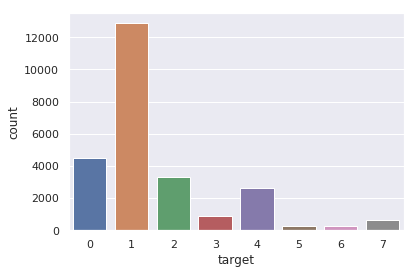

In [11]:
sns.set(style="darkgrid")
sns.countplot(ISIC_TRAIN_DF_TRUTH.target)

In [13]:
ISIC_TRAIN_DF_TRUTH.to_csv(ISIC_PATH + "ISIC_2019_Training_GroundTruth_WithTargets.csv")

In [14]:
ISIC_TRAIN_DF_TRUTH = pd.read_csv(ISIC_PATH + "ISIC_2019_Training_GroundTruth_WithTargets.csv")

In [12]:
ISIC_TRAIN_DF_METADATA.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [13]:
root_path = ROOT_PATH["train"]
imgs = []
for dirpath, dirnames, files in os.walk(root_path):
    for f in files:
        img = os.path.join(dirpath, f)
        imgs.append(img)

imgs = np.array(imgs)

In [16]:
menor_alto, menor_ancho, menor_canales = 9999, 9999, 9999
mayor_alto, mayor_ancho, mayor_canales = 0, 0, 0
for img_path in imgs:
    if ".txt" not in img_path:
        try: img = io.imread(img_path)
        except: assert False, "Error in " + img_path
        h, w, c = img.shape
        #print("Alto: {} - Ancho: {} - Canales: {}".format(h, w, c))
        if h < menor_alto or w < menor_ancho:
            menor_alto, menor_ancho = h, w
        if h > mayor_alto or w > mayor_ancho:
            mayor_alto, mayor_ancho = h, w
        if c < menor_canales: menor_canales = c
        if c > mayor_canales: mayor_canales = c

In [25]:
print("Menor img: {}x{}".format(menor_alto, menor_ancho))
print("Menor canales: {}".format(menor_canales))
print("Mayor img: {}x{}".format(mayor_alto, mayor_ancho))
print("Mayor canales: {}".format(mayor_canales))

Menor img: 450x600
Menor canales: 3
Mayor img: 1024x1024
Mayor canales: 3


## Dataloader

In [17]:
class ISIC2019_Dataset(data.Dataset):

    def __init__(self, data_partition="", transforms=None, albumentation=None, validation_size=0.15, color=True, seed=42):
        """
          - validation_patients: Hay un total de 100 pacientes
          - data_partition:
             -> Si esta vacio ("") devuelve todas las muestras de todo el TRAIN
             -> Si es "train" devuelve 1-validation_size muestras de todo el TRAIN
             -> Si es "validation" devuelve validation_size muestras de todo el TRAIN
           - color: Si se deben usar imagenes a color (True) o no (False) 
        """
        self.root_path = ROOT_PATH[data_partition]
        self.imgs = []
        for dirpath, dirnames, files in os.walk(self.root_path):
            for f in files:
                if ".txt" not in f:
                    img = os.path.join(dirpath, f)
                    self.imgs.append(img)

        self.imgs = np.array(self.imgs)
        
        random.seed(seed)
        val_images = random.sample(range(len(self.imgs)+1), int(validation_size*len(self.imgs)))
        
        if data_partition=="train":
            train_images = list(set(list(range(len(self.imgs)))) - set(val_images))
            self.imgs = self.imgs[train_images]
        elif data_partition=="validation":
            self.imgs = self.imgs[val_images]
            
        self.data_partition = data_partition
        self.albumentation = albumentation
        self.color = color
        self.transform = transforms
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):

        img_path = self.imgs[index]
        image = io.imread(img_path)
            
        img_name = img_path.split("/")[-1]
        img_name = img_name[:img_name.find(".jpg")] # quitamos la extension del nombre
        
        target = ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH.image==img_name].target.values[0]
        
        if self.transform:
            image = self.transform(image)

        if self.albumentation:
            try:
                augmented = self.albumentation_img(image=image)
                image = augmented['image']
            except: assert False, "Transform error in file: " + img_name

        return image, target

In [31]:
#train_aug = albumentations.Compose([
#                    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
#                    albumentations.CenterCrop(p=1, height=args.crop_size, width=args.crop_size),
#                    albumentations.Resize(args.img_size, args.img_size)
#                ])
train_aug_img = None
data_transforms_tensor = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                         torchvision.transforms.Resize((331,331)),
                                                         torchvision.transforms.ToTensor()])

train_dataset = ISIC2019_Dataset(data_partition="train", transforms=data_transforms_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, pin_memory=True, shuffle=True)

In [32]:
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset), 
                                                                        x_batch.max(), x_batch.min()))

Training set: 21533 samples - Max value: 1.0 - Min value: 0.0


In [20]:
print("Example batch shape: {}".format(x_batch.shape))

Example batch shape: torch.Size([64, 3, 331, 331])


In [21]:
y_batch

tensor([1, 1, 1, 0, 1, 0, 4, 1, 4, 1, 1, 1, 4, 0, 2, 1, 4, 3, 1, 2, 0, 3, 1, 4,
        2, 1, 2, 1, 1, 1, 0, 2, 4, 4, 2, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 4,
        1, 4, 2, 1, 1, 4, 3, 1, 1, 0, 1, 1, 0, 1, 2, 2])

In [26]:
def save_imgs(images, targets=None, display=False, save=True, custom_name="", num_test_samples=16, imgs_out_dir=""):
    fig=plt.figure(figsize = (7,7))
    gs1 = gridspec.GridSpec(4, 4)
    if targets is None:
        gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    else:
        gs1.update(wspace=0.025, hspace=0.275) # set the spacing between axes. 

    for i in range(num_test_samples):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        if targets is not None:
            ax1.set_title(CLASS_CATEGORIES[targets[i].item()])

        if(images[i].shape[0]==1):
            img = images[i].reshape(images[i].shape[1], images[i].shape[2])
        elif(images[i].shape[0]==3):
            img = images[i].permute(1,2,0)
        else: assert False, "Check images dims!"
        plt.imshow(img)

    if display: plt.show()
    if save:
        if custom_name!="":
            fig.savefig(imgs_out_dir+custom_name+'.png', bbox_inches='tight')
        else: assert False, "Provide a name please!"
    plt.close()

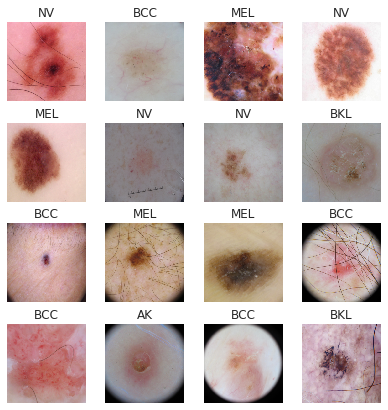

In [33]:
save_imgs(x_batch, y_batch, display=True, save=True, custom_name="train_samples2")